# EDA Notebook - Live + Historical AQI Data

### Step 1: Fetch live AQI data
We call the AQICN API to get the most recent air quality data for Karachi.  

### Step 2: Fetch historical weather data
We use Open-Meteo API to get the past 48 hours of weather features like temperature, humidity, wind speed, etc.  

### Step 3: Merge AQI and weather
We combine the datasets using the nearest timestamp to align AQI with weather.  

### Step 4: Basic EDA
- Plot AQI trend over time  
- Plot distributions and correlations  
- Check missing values  


In [17]:
# =========================
# EDA NOTEBOOK - LIVE + HISTORICAL DATA
# =========================

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ------------------ CONFIG ------------------
CITY = "Karachi"
AQICN_TOKEN = "59741dd6dd39e39a9380da6133bc2f0fe1656336"
LAT, LON = 24.8607, 67.0011  # Karachi coords
HOURS = 48  # last 48 hours of weather data


In [18]:
# ------------------ FETCH AQI ------------------
def fetch_aqi():
    url = f"https://api.waqi.info/feed/{CITY}/?token={AQICN_TOKEN}"
    response = requests.get(url)
    data = response.json()

    if data["status"] != "ok":
        return None

    iaqi = data["data"]["iaqi"]
    time_info = data["data"]["time"]

    row = {
        "timestamp": pd.to_datetime(time_info["iso"]),
        "aqi": data["data"]["aqi"],
        "pm25": iaqi.get("pm25", {}).get("v"),
        "pm10": iaqi.get("pm10", {}).get("v"),
        "no2": iaqi.get("no2", {}).get("v"),
        "so2": iaqi.get("so2", {}).get("v"),
        "co": iaqi.get("co", {}).get("v"),
        "o3": iaqi.get("o3", {}).get("v"),
    }
    return row

aqi_row = fetch_aqi()
aqi_df = pd.DataFrame([aqi_row])
print("✅ Live AQI fetched:")
aqi_df


✅ Live AQI fetched:


,timestamp,aqi,pm25,pm10,no2,so2,co,o3
0,2025-03-04 16:00:00+05:00,161,161,None,None,None,None,None


In [19]:
# ------------------ FETCH WEATHER ------------------
end_time = datetime.utcnow()
start_time = end_time - timedelta(hours=HOURS)

weather_url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={LAT}&longitude={LON}&hourly=temperature_2m,relative_humidity_2m,"
    f"wind_speed_10m,pressure_msl,precipitation&start={start_time.isoformat()}&end={end_time.isoformat()}"
)

weather_resp = requests.get(weather_url)
weather_data = weather_resp.json()

weather_df = pd.DataFrame(weather_data['hourly'])
weather_df['timestamp'] = pd.to_datetime(weather_df['time'])
weather_df.drop(columns=['time'], inplace=True)

# Rename columns to match pipeline
weather_df.rename(columns={
    "temperature_2m": "temperature",
    "relative_humidity_2m": "humidity",
    "wind_speed_10m": "wind_speed",
    "pressure_msl": "pressure"
}, inplace=True)

print("✅ Historical weather fetched:")
weather_df.head()


/tmp/ipython-input-10576912.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


✅ Historical weather fetched:


,temperature,humidity,wind_speed,pressure,precipitation,timestamp
0,10.3,66,7.9,1018.9,0.0,2026-01-24 00:00:00
1,10.2,63,9.2,1019.4,0.0,2026-01-24 01:00:00
2,10.5,61,9.7,1020.5,0.0,2026-01-24 02:00:00
3,10.9,57,12.5,1021.4,0.0,2026-01-24 03:00:00
4,12.5,47,15.7,1022.4,0.0,2026-01-24 04:00:00


In [20]:
# ------------------ FIX TIMEZONE ------------------
# Make AQI timestamp naive
aqi_df['timestamp'] = aqi_df['timestamp'].dt.tz_localize(None)

# Make weather timestamp naive (if it somehow has tz info)
weather_df['timestamp'] = weather_df['timestamp'].dt.tz_localize(None)

# ------------------ MERGE AQI + WEATHER ------------------
merged_df = pd.merge_asof(
    aqi_df.sort_values("timestamp"),
    weather_df.sort_values("timestamp"),
    on="timestamp",
    direction="nearest"
)

print("✅ Merged AQI + Weather DataFrame:")
print(merged_df.head())


✅ Merged AQI + Weather DataFrame:
            timestamp  aqi  pm25  pm10   no2   so2    co    o3  temperature  \
0 2025-03-04 16:00:00  161   161  None  None  None  None  None         10.3   

   humidity  wind_speed  pressure  precipitation  
0        66         7.9    1018.9            0.0  


In [21]:
# ===========================
# 5️⃣ BASIC DATA CHECK
# ===========================
print("INFO:\n")
print(merged_df.info())
print("\nMISSING VALUES:\n")
print(merged_df.isna().sum())
print("\nDESCRIPTIVE STATS:\n")
print(merged_df.describe())


INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      1 non-null      datetime64[ns]
 1   aqi            1 non-null      int64         
 2   pm25           1 non-null      int64         
 3   pm10           0 non-null      object        
 4   no2            0 non-null      object        
 5   so2            0 non-null      object        
 6   co             0 non-null      object        
 7   o3             0 non-null      object        
 8   temperature    1 non-null      float64       
 9   humidity       1 non-null      int64         
 10  wind_speed     1 non-null      float64       
 11  pressure       1 non-null      float64       
 12  precipitation  1 non-null      float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 236.0+ bytes
None

MISSING VALUES:

timestamp        0

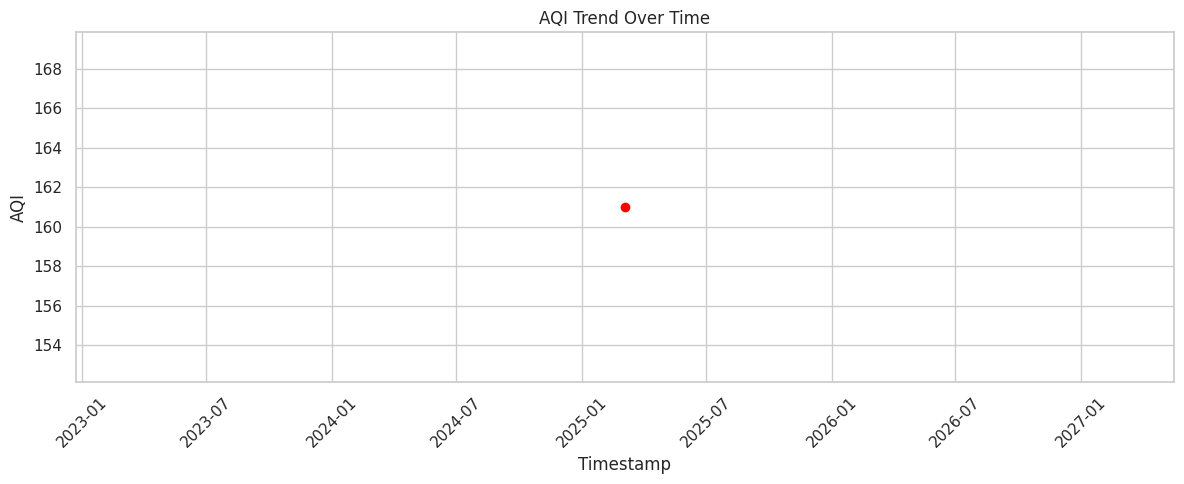

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(merged_df["timestamp"], merged_df["aqi"], marker='o', color='red')
plt.title("AQI Trend Over Time")
plt.xlabel("Timestamp")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
# Summary statistics for AQI and weather
merged_df.describe()


,timestamp,aqi,pm25,temperature,humidity,wind_speed,pressure,precipitation
count,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,2025-03-04 16:00:00,161.0,161.0,10.3,66.0,7.9,1018.9,0.0
min,2025-03-04 16:00:00,161.0,161.0,10.3,66.0,7.9,1018.9,0.0
25%,2025-03-04 16:00:00,161.0,161.0,10.3,66.0,7.9,1018.9,0.0
50%,2025-03-04 16:00:00,161.0,161.0,10.3,66.0,7.9,1018.9,0.0
75%,2025-03-04 16:00:00,161.0,161.0,10.3,66.0,7.9,1018.9,0.0
max,2025-03-04 16:00:00,161.0,161.0,10.3,66.0,7.9,1018.9,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Missing values check
merged_df.isnull().sum()


,0
timestamp,0
aqi,0
pm25,0
pm10,1
no2,1
so2,1
co,1
o3,1
temperature,0
humidity,0


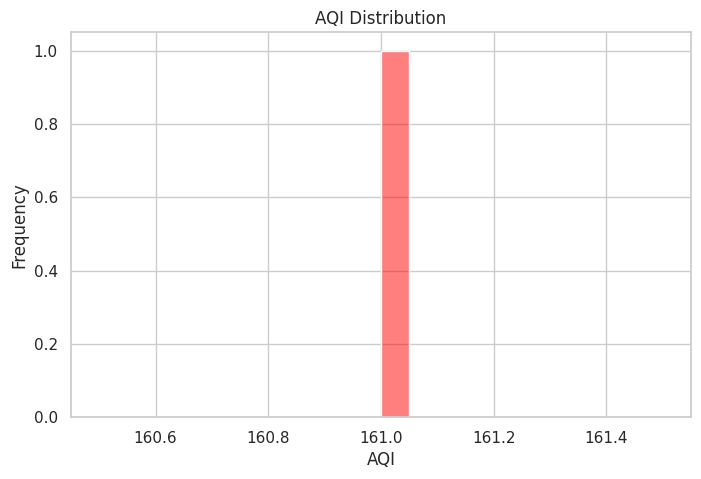

In [25]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(merged_df['aqi'], bins=20, kde=True, color='red')
plt.title("AQI Distribution")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.show()


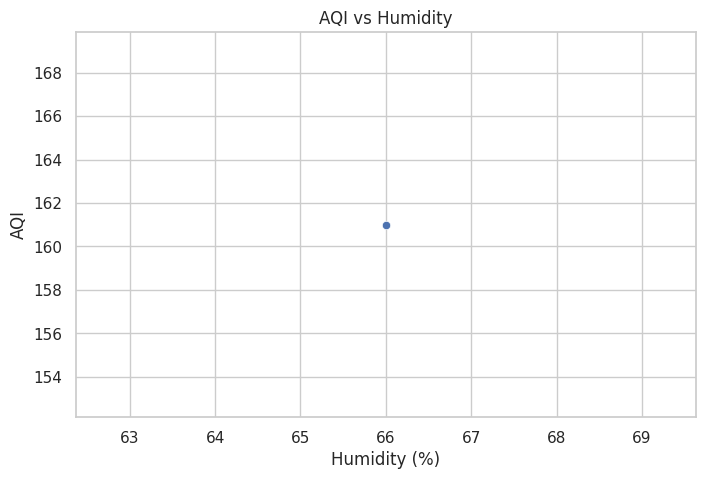

In [26]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='humidity', y='aqi', data=merged_df)
plt.title("AQI vs Humidity")
plt.xlabel("Humidity (%)")
plt.ylabel("AQI")
plt.show()


/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


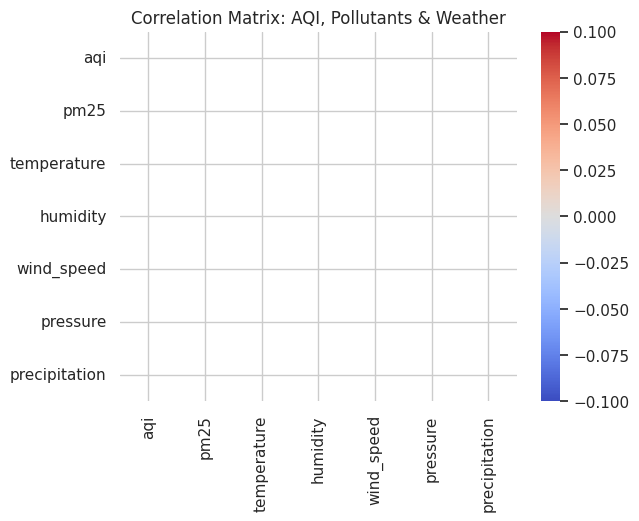

In [27]:
# Correlation heatmap
corr = merged_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix: AQI, Pollutants & Weather")
plt.show()


In [28]:
# Check the columns first
print("Columns in merged_df:")
print(merged_df.columns.tolist())


Columns in merged_df:
['timestamp', 'aqi', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3', 'temperature', 'humidity', 'wind_speed', 'pressure', 'precipitation']


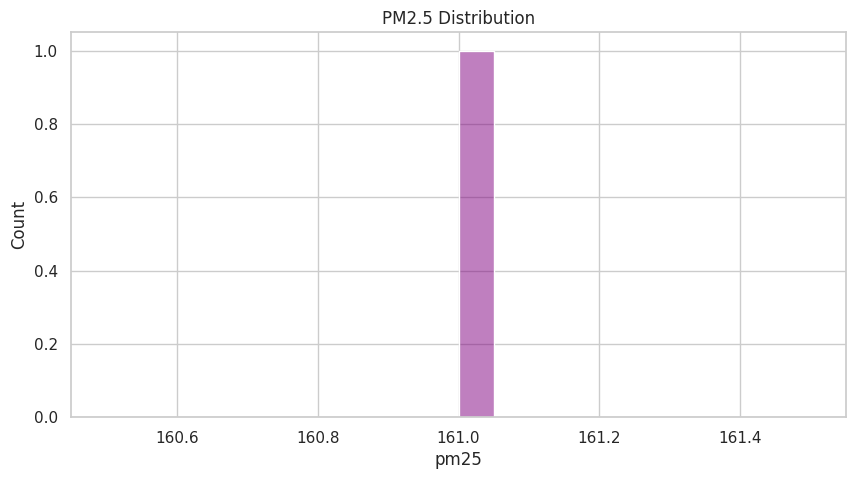

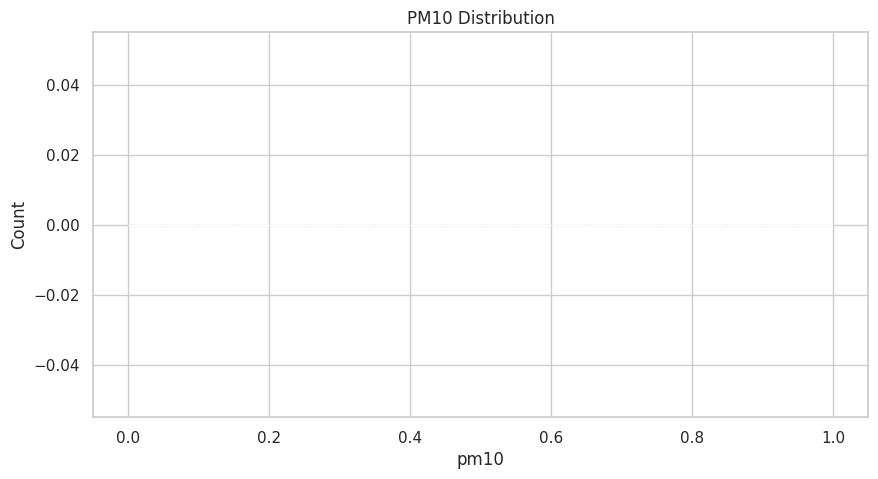

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(merged_df['pm25'], bins=20, kde=True, color='purple')
plt.title("PM2.5 Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(merged_df['pm10'], bins=20, kde=True, color='orange')
plt.title("PM10 Distribution")
plt.show()


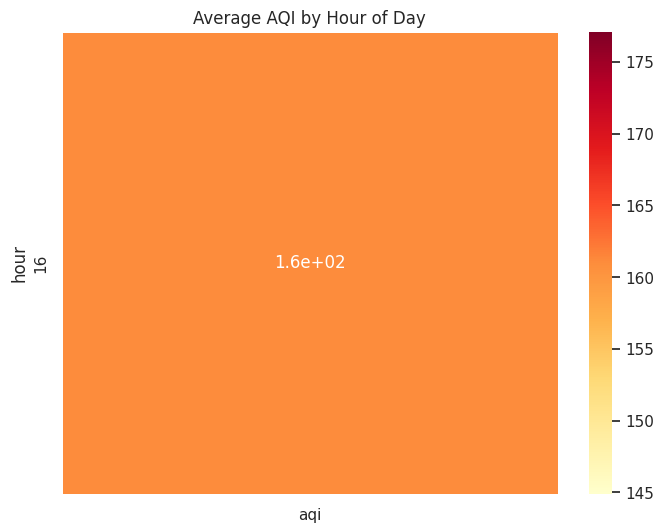

In [30]:
# Extract hour of day
merged_df['hour'] = merged_df['timestamp'].dt.hour

# Pivot table: hours vs AQI
hourly_aqi = merged_df.pivot_table(values='aqi', index='hour', aggfunc='mean')

plt.figure(figsize=(8,6))
sns.heatmap(hourly_aqi, annot=True, cmap="YlOrRd", linewidths=0.5)
plt.title("Average AQI by Hour of Day")
plt.show()


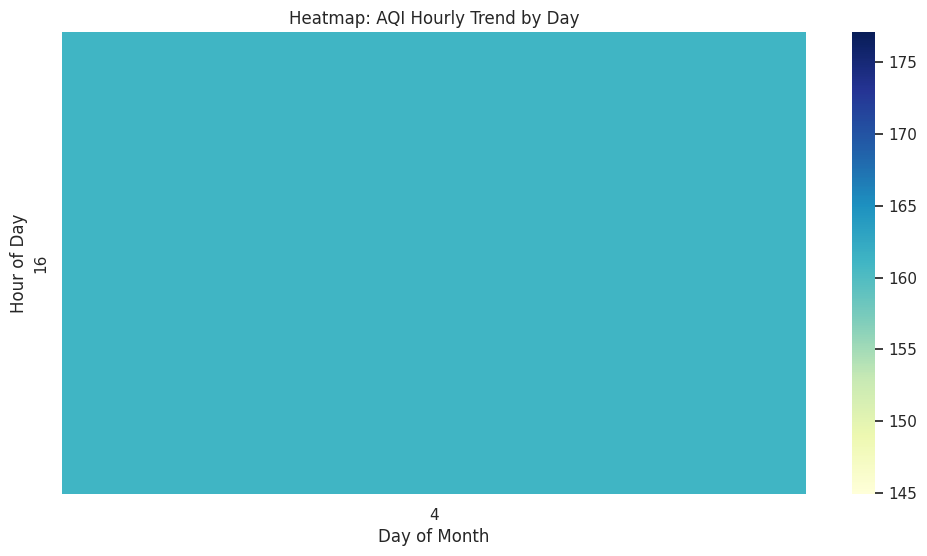

In [31]:
# Extract day of month
merged_df['day'] = merged_df['timestamp'].dt.day

# Pivot: day vs hour
daily_hourly_aqi = merged_df.pivot_table(values='aqi', index='hour', columns='day', aggfunc='mean')

plt.figure(figsize=(12,6))
sns.heatmap(daily_hourly_aqi, cmap="YlGnBu", annot=False)
plt.title("Heatmap: AQI Hourly Trend by Day")
plt.xlabel("Day of Month")
plt.ylabel("Hour of Day")
plt.show()


/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


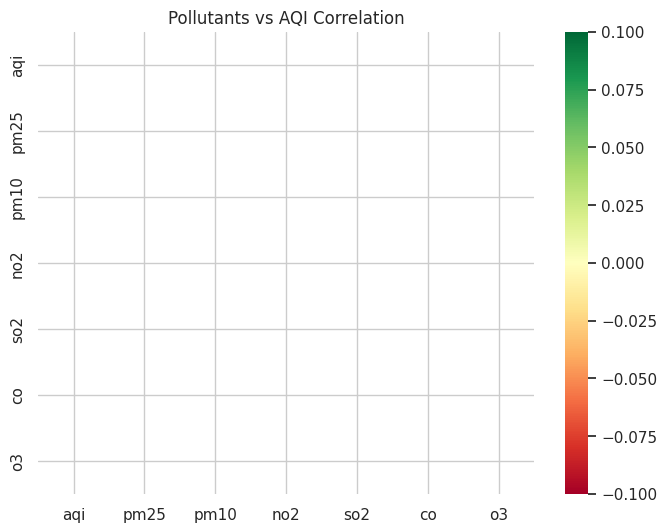

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(merged_df[['aqi','pm25','pm10','no2','so2','co','o3']].corr(), annot=True, cmap='RdYlGn')
plt.title("Pollutants vs AQI Correlation")
plt.show()
